## Import dependencies

In [48]:
# Standard libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# TensorFlow / Keras
import tensorflow as tf
from keras.models import Model
from keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense,
    Flatten, ReLU, Bidirectional, LSTM, BatchNormalization,
    Activation, Multiply, Lambda
)
from keras.optimizers import Nadam
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger


## Import Data

In [3]:
df = pd.read_pickle('population_splits.pkl')
df

{'Train': {'Positive':             Transcript Gene Name  Chrom Strand Location on Transcript  \
  134899  XM_005258465.6  HNRNPUL1  chr19      +                  5 UTR   
  134898  XM_011526394.4  HNRNPUL1  chr19      +                   aTIS   
  146677     NM_005765.3   ATP6AP2   chrX      +                  5 UTR   
  146684     NM_005765.3   ATP6AP2   chrX      +                   aTIS   
  146641  XM_017029594.3     POLA1   chrX      +                   aTIS   
  ...                ...       ...    ...    ...                    ...   
  2501       NM_015871.5    ZNF593   chr1      +                   aTIS   
  131288     NM_007065.4     CDC37  chr19      -                  5 UTR   
  131293     NM_007065.4     CDC37  chr19      -                   aTIS   
  130850     NM_025241.3     UBXN6  chr19      -                   aTIS   
  131176  XM_005272478.4    HNRNPM  chr19      +                   aTIS   
  
         Start Codon  Transcript Index  Coordinate     Label  \
  134899    

## Model Training

In [4]:
window_size = 100
X_train = np.random.rand(10, window_size+3, 4)
y_train = np.random.randint(0, 2, size=(10, 1))

In [29]:
random.seed(42)
tf.random.set_seed(5)
model_input_seq = Input(shape=[window_size+3, 4])

x = ReLU()(Conv1D(512, 8, padding='valid', strides=1, name='seq_conv')(model_input_seq))
x = MaxPooling1D(pool_size=3, strides=3, name='bin_pool')(x)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(units=16, return_sequences=True, name='bin_lstm'))(x)
x = Flatten(name='conv_flatten')(x)

bin_x = ReLU()(Dense(512, kernel_initializer='glorot_uniform', name='bin_dense0')(x))
bin_x = Dropout(0.5)(bin_x)
bin_x = ReLU()(Dense(256, kernel_initializer='glorot_uniform', name='bin_dense1')(bin_x))
bin_x = Dropout(0.5)(bin_x)
bin_x = ReLU()(Dense(256, kernel_initializer='glorot_uniform', name='bin_dense2')(bin_x))
bin_x = Dropout(0.5)(bin_x)
bin_x = ReLU()(Dense(64, name='bin_dense4')(bin_x))
bin_x = Dense(1, activation='sigmoid', name='class_predictions')(bin_x)

model = Model(inputs=model_input_seq, outputs=bin_x, name='model')
model.compile(optimizer=Nadam(learning_rate=0.001),
              loss=BinaryCrossentropy(reduction='sum_over_batch_size', name='binary_crossentropy'))
model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 103, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ seq_conv (Conv1D)               │ (None, 96, 512)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 96, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_pool (MaxPooling1D)         │ (None, 32, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 32, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 32, 32)         │        67,712 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_flatten (Flatten)          │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense0 (Dense)              │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense1 (Dense)              │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense2 (Dense)              │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bin_dense4 (Dense)              │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ class_predictions (Dense)       │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 823,041 (3.14 MB)

 Trainable params: 823,041 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


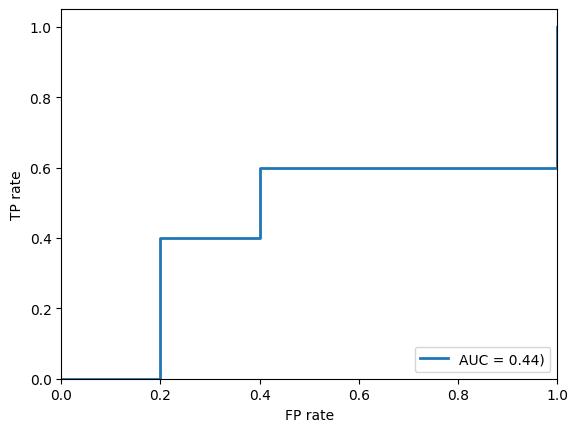

In [30]:
y_pred_prob = model.predict(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.legend(loc="lower right")
plt.show()

In [31]:
random.seed(42)
tf.random.set_seed(5)
model_input_seq = Input(shape=[window_size+3, 4])

# add more convolutional layers
x = Conv1D(256, 8, padding='valid', strides=1, activation='relu')(model_input_seq)
x = MaxPooling1D(pool_size=2, strides=2)(x)
x = Dropout(0.3)(x)
x = Conv1D(128, 5, padding='valid', strides=1, activation='relu')(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)
x = Dropout(0.3)(x)

# use a deeper LSTM layer
x = Bidirectional(LSTM(units=512, return_sequences=True))(x)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(units=256, return_sequences=False))(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

improved_model = Model(inputs=model_input_seq, outputs=output)
improved_model.compile(
    optimizer=Nadam(learning_rate=0.0005),
    loss=BinaryCrossentropy(reduction='sum_over_batch_size'),
    metrics=['AUC']
)
improved_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 103, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 96, 256)        │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 48, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 48, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 44, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 22, 1024)       │     2,625,536 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 22, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 512)            │     2,623,488 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,593,985 (21.34 MB)

 Trainable params: 5,593,985 (21.34 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


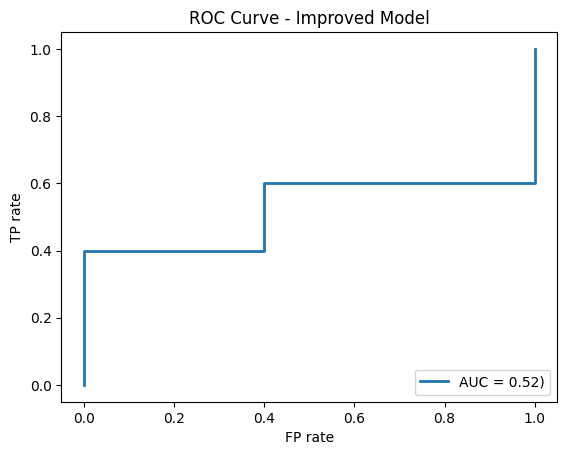

In [32]:
y_pred_prob_improved = improved_model.predict(X_train)
fpr_improved, tpr_improved, thresholds_improved = roc_curve(y_train, y_pred_prob_improved)
roc_auc_improved = auc(fpr_improved, tpr_improved)
plt.figure()
plt.plot(fpr_improved, tpr_improved, lw=2, label=f'AUC = {roc_auc_improved})')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC Curve - Improved Model')
plt.legend(loc="lower right")
plt.show()

In [ ]:
random.seed(42)
tf.random.set_seed(5)
os.makedirs('logs', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)

window_size = X_train.shape[1] - 3

for trial in range(5):
    print(f"\n--- Trial {trial + 1} ---")

    # Sample balanced sets
    neg_train = df['Train']['Negative'].sample(n=len(df['Train']['Positive']), replace=True).copy()
    neg_val = df['Validation']['Negative'].sample(n=len(df['Validation']['Positive']), replace=True).copy()
    neg_test = df['Test']['Negative'].sample(n=len(df['Test']['Positive']), replace=True).copy()

    # Combine and shuffle
    train_df = pd.concat([df['Train']['Positive'], neg_train], ignore_index=True).sample(frac=1)
    val_df = pd.concat([df['Validation']['Positive'], neg_val], ignore_index=True).sample(frac=1)
    test_df = pd.concat([df['Test']['Positive'], neg_test], ignore_index=True).sample(frac=1)

    # Prepare inputs
    X_train = np.array(train_df['One Hot Encoding'].tolist())
    y_train = np.array(train_df['Binary Label'].tolist()).reshape(-1, 1)
    X_test = np.array(test_df['One Hot Encoding'].tolist())
    y_test = np.array(test_df['Binary Label'].tolist()).reshape(-1, 1)

    # Model definition
    input_seq = Input(shape=(window_size + 3, 4), name='input_seq')

    x = Conv1D(512, kernel_size=8, strides=1, padding='valid')(input_seq)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=3, strides=3)(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(32, return_sequences=False))(x)
    x = Flatten()(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_seq, outputs=output)

    model.compile(
        optimizer=Nadam(learning_rate=1e-3),
        loss=BinaryCrossentropy(),
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )

    model_path = f"checkpoints/trial_{trial}_best_model.keras"
    logger_path = f"logs/trial_{trial}_training.csv"

    callbacks = [
        EarlyStopping(monitor='val_auc', patience=4, mode='max', restore_best_weights=True),
        ModelCheckpoint(model_path, monitor='val_auc', mode='max', save_best_only=True),
        CSVLogger(logger_path)
    ]

    model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=20,
        batch_size=32,
        callbacks=callbacks,
        verbose=2
    )

    print("Test AUC:", model.evaluate(X_test, y_test, verbose=0)[1])



--- Trial 1 ---
Epoch 1/20
254/254 - 19s - 76ms/step - auc: 0.5152 - loss: 0.6938 - val_auc: 0.5171 - val_loss: 0.6934
Epoch 2/20
254/254 - 18s - 72ms/step - auc: 0.5284 - loss: 0.6910 - val_auc: 0.5185 - val_loss: 0.6930
Epoch 3/20
254/254 - 20s - 80ms/step - auc: 0.5363 - loss: 0.6902 - val_auc: 0.5347 - val_loss: 0.6930
Epoch 4/20
254/254 - 22s - 86ms/step - auc: 0.5375 - loss: 0.6899 - val_auc: 0.5327 - val_loss: 0.6928
Epoch 5/20
254/254 - 20s - 79ms/step - auc: 0.5415 - loss: 0.6894 - val_auc: 0.5263 - val_loss: 0.6923
Epoch 6/20
254/254 - 19s - 76ms/step - auc: 0.5436 - loss: 0.6888 - val_auc: 0.5591 - val_loss: 0.6919
Epoch 7/20
254/254 - 20s - 78ms/step - auc: 0.5467 - loss: 0.6892 - val_auc: 0.5596 - val_loss: 0.6908
Epoch 8/20
254/254 - 20s - 78ms/step - auc: 0.5526 - loss: 0.6870 - val_auc: 0.5497 - val_loss: 0.6933
Epoch 9/20
254/254 - 20s - 78ms/step - auc: 0.5611 - loss: 0.6858 - val_auc: 0.5354 - val_loss: 0.6916
Epoch 10/20
254/254 - 20s - 81ms/step - auc: 0.5750 - lo